## Dirichlet Boundary Condition on Complex Shape

The way to impose Dirichlet boundary conditions with complex shape is to have the following trial solution:

$$
u(\vec{x}) = A_D(\vec{x}) + L_D(\vec{x})u_{NN}(\vec{x})
$$

where $u_{NN}(\vec{x})$ is the output of the neural network, $L_D(\vec{x})$ is a function that evaluates to $0$ when $\vec{x}$ on the Dirichlet boundary (but non-zero elsewhere) and $A_D(\vec{x})$ is a function that satisfy the Dirichlet boundary condition on the boundary. Both $L_D(\vec{x})$ and $A_D(\vec{x})$ can be created by thin-plate spline.

## Thin Plate Spline

(the physics intuition behind the 'thin plate' part skipped, I don't understand that.) 2-D thin plate spline can be seen as a way of interpolating $N$ 3-D "control points" $(x_i, y_i, u_i)$ ($i = 1, 2, ..., N$) to get a surface $u(x, y)$. The interpolated surface will be a linear combination of the following basis functions:

$$
f_i(x, y) = r_i(x, y)^2\ln{r_i(x, y)^2}, \text{ where } r_i(x, y) = \sqrt{(x-x_i)^2 + (y-y_i)^2 + d^2}, (i = 1, 2, ..., N) \\
f_{N+1}(x, y) = x \\
f_{N+2}(x, y) = y \\
f_{N+3}(x, y) = 1
$$

The $N+3$ weights $F_i$ ($i = 1, 2, ..., N+3$) are fitted by solving the following $N+3$ equations:

$$
\sum_{i=1}^{N+3}F_if_i(x, y) = u_i, i = 1, 2, ..., N \\
\sum_{i=1}^{N}F_i x = 0 \\
\sum_{i=1}^{N}F_i y = 0 \\
\sum_{i=1}^{N}F_i = 0
$$

## Creating A_D and L_D

### A_D

$A_D(\vec{x})$ is a function that satisfy the Dirichlet boundary condition on the boundary. Suppose we are solving a differential equation regarding $u(x, y)$ and the Dirichlet boundary is $u(x, y) = g(x, y)$, then we can select a collection of "control points" on the boundary: $(x_i, y_i, g(x_i, y_i))$. $A_D(x, y)$ can be interpolated using thin plate spline with these points.

### L_D

$L_D(\vec{x})$ is a function that evaluates to $0$ when $\vec{x}$ on the Dirichlet boundary (but non-zero elsewhere). For a circular boundary with radius $r$, we can define

$$
L_D(x, y) = r^2 - (x^2 + y^2)
$$

For a non-circular boundary, we can first map the boundary to a circle with some function $m(x, y): (x, y) \mapsto (\tilde{x}, \tilde{x})$ such that for all points $(x_i, y_i)$ on the Dirichlet boundary, the mapped points $(\tilde{x_i}, \tilde{y_i})$ fall on the circle we specified, then we define

$$
L_D(x, y) = r^2 - (\tilde{x}^2 + \tilde{y}^2)
$$

The mapping $m(x, y)$ can be created by thin plate spline as well. In this case, we need 2 set of weights, one set to create the values of the mapped x-coordinate, the other to create the values of the mapped y-coordinate.

In [1]:
# See http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.105.1166&rep=rep1&type=pdf for clarification
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Point:
    
    def __repr__(self):
        return f'Point({self.x})'
    
    def __init__(self, x):
        self.x = x
        self.dim = len(x)

class DirichletControlPoint(Point):
    
    def __repr__(self):
        return f'DirichletControlPoint({self.x}, val={self.val})'
    
    def __init__(self, x, val):
        super().__init__(x)
        self.val = val

class TargetPoint(Point):
    
    def __repr__(self):
        return f'TargetPoint({self.x})'
    
    def __init__(self, x):
        super().__init__(x)

In [3]:
def create_mapping_targets(control_points, center, r=0.5):
    
    # remove the control points that are defined more than once
    coords = set()
    unique = []
    for cp in control_points:
        if cp.x not in coords:
            coords.add(cp.x)
            unique.append(cp)
    
    # sort the control points 'clockwise' (from 0 to -2pi)
    def clockwise(cp):
        return (
            1 if cp.x[1]-center[1] > 0 else -1,
            (cp.x[0]-center[0])/(cp.x[1]-center[1]-1e-8)
        )
    control_points = sorted(unique, key=clockwise)

    # create equally spaced target points
    target_points = [
        TargetPoint( (r*np.cos(theta), r*np.sin(theta)) )
        for theta in -np.linspace(0, 2*np.pi, len(control_points), endpoint=False)
    ]
    
    assert len(control_points) == len(target_points)
    return control_points, target_points

In [4]:
def distance(p, cp, stiffness=0.01):
    return np.sqrt(
        sum((d_p-d_cp)**2 for d_p, d_cp in zip(p.x, cp.x)) 
        + stiffness**2
    )

In [5]:
def solve_tps(control_points, targets):
    n_dims = control_points[0].dim
    n_pnts = len(control_points)
    n_eqts = n_coef = n_dims+n_pnts+1
    
    def equation_weights(equation_no): # or here, this and mapping should be consistent
        weights = np.zeros(n_coef)
        if equation_no < n_pnts:
            p = control_points[equation_no]
            for i in range(n_pnts):
                r = distance(p, control_points[i])
                weights[i] = r**2 * np.log(r**2)
            weights[n_pnts] = 1.0
            for i in range(n_dims):
                weights[n_pnts+1+i] = p.x[i]
        elif equation_no <  n_pnts + n_dims:
            j_dim = equation_no - n_pnts
            for i in range(n_pnts):
                weights[i] = control_points[i].x[j_dim]
        elif equation_no == n_pnts + n_dims:
            weights[:n_pnts] = 1.0
        return weights
    
    W = np.zeros((n_eqts, n_coef))
    for equation_no in range(n_eqts):
        W[equation_no] = equation_weights(equation_no)
    b = np.zeros(n_eqts)
    b[:n_pnts] = targets
    return np.linalg.solve(W, b)

In [6]:
def create_L_D(control_points, target_points, target_r=0.5):
    coefs_of_dim = [
        solve_tps(control_points, np.array([tp.x[i] for tp in target_points]))
        for i in range(target_points[0].dim)
    ]    
    n_dims = control_points[0].dim
    n_pnts = len(control_points)
    n_eqts = n_coef = n_dims+n_pnts+1
    
    def mapping(p):
        
        def map_dim(i):
            dim_i_mapped = 0.0
            for coef, cp in zip(coefs_of_dim[i][:n_pnts], control_points): # coef: first len(control_points) weights
                r = distance(p, cp)
                dim_i_mapped += coef * r**2 * np.log(r**2)
            dim_i_mapped += coefs_of_dim[i][n_pnts]
            for j_dim in range(p.dim):
                dim_i_mapped += coefs_of_dim[i][n_pnts+1+j_dim] * p.x[j_dim]
            return dim_i_mapped
        
        return Point(x=tuple(map_dim(i) for i in range(p.dim)))

    
    def L_D(p):
        return target_r**2 - sum(d**2 for d in mapping(p).x)
    
    return L_D

In [7]:
def create_A_D(control_points, r=0.5):
    coefs = solve_tps(control_points, np.array([cp.val for cp in control_points]))  
    n_dims = control_points[0].dim
    n_pnts = len(control_points)
    n_eqts = n_coef = n_dims+n_pnts+1
    
    def A_D(p):
        fitted_val = 0.0
        for coef, cp in zip(coefs, control_points): # coef: first len(control_points) weights
            r = distance(p, cp)
            fitted_val += coef * r**2 * np.log(r**2)
        fitted_val += coefs[n_pnts]
        for j_dim in range(p.dim):
            fitted_val += coefs[n_pnts+1+j_dim] * p.x[j_dim]
        return fitted_val
        
        return Point(x=tuple(map_dim(i) for i in range(p.dim)))
    
    return A_D

In [8]:
control_points_square = []
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(x=(0, i), val=0))
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(x=(1, i), val=0))
for i in np.linspace(1, 0, 11):
    control_points_square.append(DirichletControlPoint(x=(i, 0), val=0))
for i in np.linspace(0, 1, 11):
    control_points_square.append(DirichletControlPoint(x=(i, 1), val=0))
    
control_points_square[:5]

[DirichletControlPoint((0, 0.0), val=0),
 DirichletControlPoint((0, 0.1), val=0),
 DirichletControlPoint((0, 0.2), val=0),
 DirichletControlPoint((0, 0.30000000000000004), val=0),
 DirichletControlPoint((0, 0.4), val=0)]

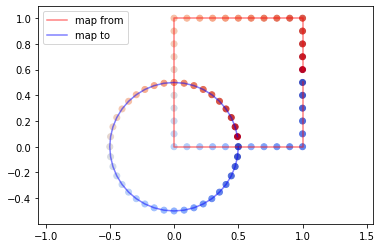

In [9]:
control_points_square, target_points_square = create_mapping_targets(control_points_square, (0.5, 0.5))

xs_from = [cp.x[0] for cp in control_points_square]
ys_from = [cp.x[1] for cp in control_points_square]
plt.plot(xs_from, ys_from, c='red', alpha=0.5, label='map from')
plt.scatter(xs_from, ys_from, c=range(len(xs_from)), cmap='coolwarm')
xs_to = [tp.x[0] for tp in target_points_square]
ys_to = [tp.x[1] for tp in target_points_square]
plt.plot(xs_to, ys_to, c='blue', alpha=0.5, label='map to')
plt.scatter(xs_to, ys_to, c=range(len(xs_to)), cmap='coolwarm')
plt.legend()
plt.axis('equal');

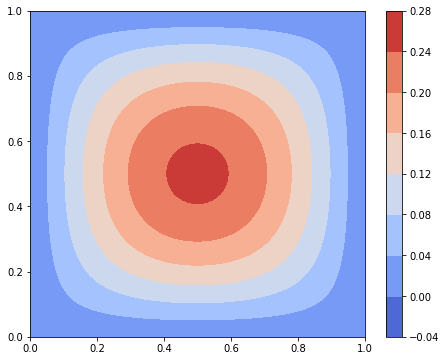

In [10]:
L_D_square = create_L_D(control_points_square, target_points_square)

xs = np.linspace(0, 1, 101)
ys = np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
points = [Point(x=(dim0, dim1)) for dim0, dim1 in zip(xx, yy)]
lds = [L_D_square(p) for p in points]

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, lds, cmap='coolwarm')
cbar = fig.colorbar(cs)

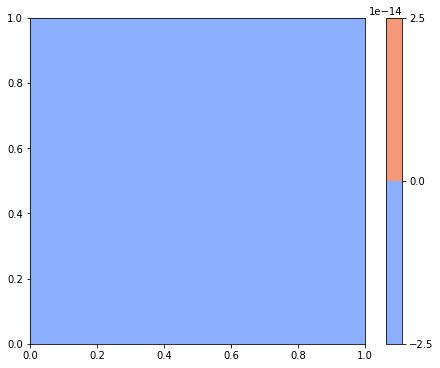

In [11]:
A_D_square = create_A_D(control_points_square)

xs = np.linspace(0, 1, 101)
ys = np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
points = [Point(x=(dim0, dim1)) for dim0, dim1 in zip(xx, yy)]
ads = [A_D_square(p) for p in points]

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, ads, cmap='coolwarm')
cbar = fig.colorbar(cs)

In [12]:
control_points_star = []
for rad in np.linspace(0, 0.5*np.pi, 21):
    x1, x2 = 1.0 - np.sin(rad), 1.0 - np.cos(rad)
    val = x1**2 + x2**2
    control_points_star.append(DirichletControlPoint(x=(x1,  x2), val=val))
    control_points_star.append(DirichletControlPoint(x=(-x1, x2), val=val))
    control_points_star.append(DirichletControlPoint(x=(x1, -x2), val=val))
    control_points_star.append(DirichletControlPoint(x=(-x1,-x2), val=val))
    
control_points_star[:5]

[DirichletControlPoint((1.0, 0.0), val=1.0),
 DirichletControlPoint((-1.0, 0.0), val=1.0),
 DirichletControlPoint((1.0, -0.0), val=1.0),
 DirichletControlPoint((-1.0, -0.0), val=1.0),
 DirichletControlPoint((0.9215409042721551, 0.003082666266872036), val=0.8492471410780542)]

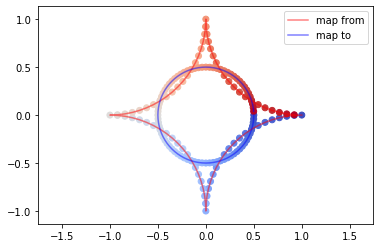

In [13]:
control_points_star, target_points_star = create_mapping_targets(control_points_star, (0.0, 0.0))

xs_from = [cp.x[0] for cp in control_points_star]
ys_from = [cp.x[1] for cp in control_points_star]
plt.plot(xs_from, ys_from, c='red', alpha=0.5, label='map from')
plt.scatter(xs_from, ys_from, c=range(len(xs_from)), cmap='coolwarm')
xs_to = [tp.x[0] for tp in target_points_star]
ys_to = [tp.x[1] for tp in target_points_star]
plt.plot(xs_to, ys_to, c='blue', alpha=0.5, label='map to')
plt.scatter(xs_to, ys_to, c=range(len(xs_to)), cmap='coolwarm')
plt.legend()
plt.axis('equal');

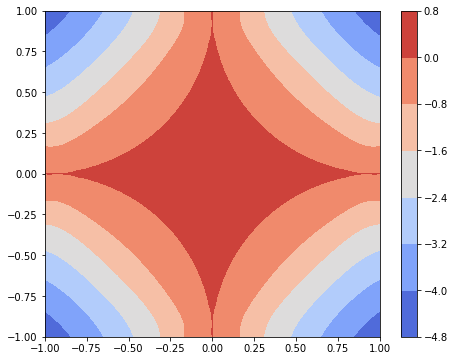

In [14]:
L_D_square = create_L_D(control_points_star, target_points_star)

xs = np.linspace(-1, 1, 101)
ys = np.linspace(-1, 1, 101)
xx, yy = np.meshgrid(xs, ys)
points = [Point(x=(dim0, dim1)) for dim0, dim1 in zip(xx, yy)]
lds = [L_D_square(p) for p in points]

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, lds, cmap='coolwarm')
cbar = fig.colorbar(cs)

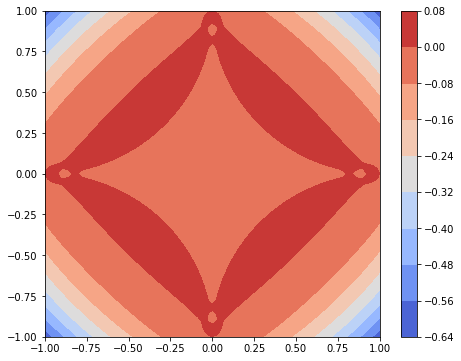

In [15]:
A_D_star = create_A_D(control_points_star)

xs = np.linspace(-1, 1, 101)
ys = np.linspace(-1, 1, 101)
xx, yy = np.meshgrid(xs, ys)
points = [Point(x=(dim0, dim1)) for dim0, dim1 in zip(xx, yy)]
ads = [A_D_star(p) for p in points]

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, ads-xx**2-yy**2, cmap='coolwarm')
cbar = fig.colorbar(cs)